# How to model immunity

In this tutorial, we are going to simulate the spread of Covid-19 in the case of a virus variant that is potentially resistant to immunity. We will first introduce the relevant immunity related variables that govern the model. Afterwards we will look at a simulation comparing how immunity and virus strains that are very resistant to it, interact in the model. 

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sid
from sid.config import INDEX_NAMES

warnings.filterwarnings("ignore")
np.random.seed(0)

## Preparation

For the simulation we need to prepare several objects which are identical to the ones from the tutorial on simulating [multiple virus strain](how_to_simulate_multiple_virus_strains.ipynb).

### Initial states

In [2]:
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
initial_states.head()

,age_group,region
0,50-59,North
1,0-9,South
2,30-39,South
3,30-39,North
4,70-79,South


### Contact Models

In [3]:
def meet_distant(states, params, seed):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, seed):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

### Initial conditions

For the initial conditions, we assume a two-day burn-in period. On the first day, 50 people are infected with the base virus, on the second day one halve of 50 people has the old and the other halve the new variant.

Each column in the DataFrame is a categorical. Infected individuals have a code for the variant, all others have NaNs.

In [4]:
infected_first_day = set(np.random.choice(10_000, size=50, replace=False))
first_day = pd.Series([pd.NA] * 10_000)
first_day.iloc[list(infected_first_day)] = "base"

infected_second_day_old_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day), size=25, replace=False
    )
)
infected_second_day_new_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day - infected_second_day_old_variant),
        size=25,
        replace=False,
    )
)

second_day = pd.Series([pd.NA] * 10_000)
second_day.iloc[list(infected_second_day_old_variant)] = "base"
second_day.iloc[list(infected_second_day_new_variant)] = "b117"

initial_infections = pd.DataFrame(
    {
        pd.Timestamp("2020-02-25"): pd.Categorical(
            first_day, categories=["base", "b117"]
        ),
        pd.Timestamp("2020-02-26"): pd.Categorical(
            second_day, categories=["base", "b117"]
        ),
    }
)

initial_conditions = {"initial_infections": initial_infections, "initial_immunity": 50}

### Parameters

In [5]:
epidemiological_parameters = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)

assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)

disease_params = sid.load_epidemiological_parameters()

params = pd.concat([disease_params, epidemiological_parameters, assort_probs])

In [6]:
params

value  note  \
category             subcategory        name                              
health_system        icu_limit_relative icu_limit_relative  50.00   NaN   
cd_infectious_true   all                1                    0.39   NaN   
                                        2                    0.35   NaN   
                                        3                    0.22   NaN   
                                        5                    0.04   NaN   
...                                                           ...   ...   
infection_prob       household          household            0.20   NaN   
assortative_matching close              age_group            0.50   NaN   
                                        region               0.90   NaN   
                     distant            age_group            0.50   NaN   
                                        region               0.90   NaN   

                                                            source  
category             subcategory        name                        
health_system        icu_limit_relative icu_limit_relative     NaN  
cd_infectious_true   all                1                      NaN  
                                        2                      NaN  
                                        3                      NaN  
                                        5                      NaN  
...                                                            ...  
infection_prob       household          household              NaN  
assortative_matching close              age_group              NaN  
                                        region                 NaN  
                     distant            age_group              NaN  
                                        region                 NaN  

[136 rows x 3 columns]

## Immunity related variables

There are two broad categories we need to consider.

#### Immunity Level

Variables related to the immunity level describe the immunity status that an individual achieves after a given event has occured. In our case the events are either an _infection_ or a _vaccination_. The two parameters are set in the params data frame as

In [7]:
params.loc[("immunity", "immunity_level", "from_infection"), "value"] = 0.99
params.loc[("immunity", "immunity_level", "from_vaccination"), "value"] = 0.8

#### Immunity Waning

Variables related to the immunity waning describe how the level of an individual increases and decreases over time. To avoid an overly compliated functional form we use a simple piecewise polynomial. The first piece describes the ascending part right after an event until the maximum level is achieved. For instance, after a vaccination we expect at least 14 days before an individual is fully protected. The second piece describes the descending part after the maximum is attained. The parameters governing the functional form are set in the params data frame as below. See also the below example figure.

In [8]:
params.loc[
    ("immunity", "immunity_waning", "time_to_reach_maximum_infection"), "value"
] = 7
params.loc[
    ("immunity", "immunity_waning", "time_to_reach_maximum_vaccination"), "value"
] = 28
params.loc[
    ("immunity", "immunity_waning", "slope_after_maximum_infection"), "value"
] = -0.0001
params.loc[
    ("immunity", "immunity_waning", "slope_after_maximum_vaccination"), "value"
] = -0.0002

#### Example Figure

Note that the coefficients are computed using the parameter values defined above. When calling the simulate function this is done automatically under the hood.

In [9]:
coef = sid.update_states._get_waning_immunity_coefficients(params, event="vaccination")

time_to_maximum = int(coef["time_to_reach_maximum"])

days = np.arange(365)
immunity_level = np.zeros(365)

immunity_level[:time_to_maximum] = (
    coef["slope_before_maximum"] * days[:time_to_maximum] ** 3
)

immunity_level[time_to_maximum:] = (
    coef["intercept_after_maximum"]
    + coef["slope_after_maximum"] * days[time_to_maximum:]
)

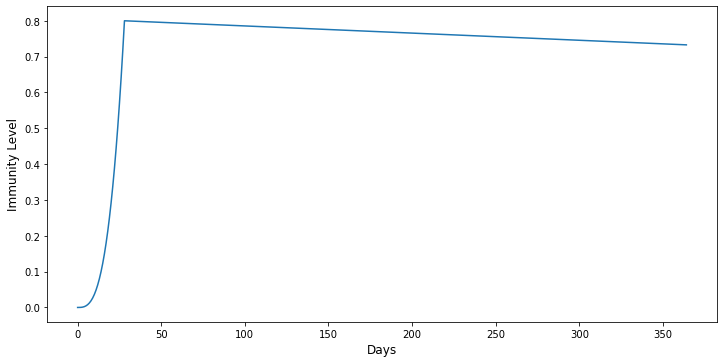

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.5)

ax.plot(days, immunity_level)
ax.set_xlabel("Days", size=12)
ax.set_ylabel("Immunity Level", size=12)

plt.show()

## Additional objects to model immunity

In the model, immunity is assumed to be a factor between 0 and 1. A non-zero immunity level can arise either through infection or vaccination. If an individual has contact with an infectious person state-dependent infection probability, say $p$, is multiplied with the factor $(1 - \text{immunity})$. But we know that the effect of immunity is heterogeneous dependent on the virus strain. To model this phenomenon we include another virus dependent factor, which we call ``immunity_resistance_factor``. The updated infection probability is then

\begin{align}
    p \leftarrow p \times \left(1 - \text{immunity_resistance} \times \text{immunity} \right) \,.
\end{align}

From this expression it is clear that, for the immunity resistance factor, values close to 0 imply that immunity barely affects the infection probability, while values close to one imply that the immunity level influences the infection probability directly. Now lets return to the simulation.

In [11]:
for virus, cf, irf in [("base", 1, 1), ("b117", 1.3, 0.5)]:
    params.loc[("virus_strain", virus, "contagiousness_factor"), "value"] = cf
    params.loc[("virus_strain", virus, "immunity_resistance_factor"), "value"] = irf

## Run the simulation

Now we will simulate this population over 200 periods. To compare the effects of the immunity resistance parameter we run the simulation for three parameter values: 0, 0.5 and 1.

In [12]:
resistance_factors = [0, 0.5, 1]

df_dict = {}
for value in resistance_factors:

    # update the immunity resistance factor
    params.loc[("virus_strain", "b117", "immunity_resistance_factor"), "value"] = value

    # simulate
    simulate = sid.get_simulate_func(
        initial_states=initial_states,
        contact_models=contact_models,
        params=params,
        initial_conditions=initial_conditions,
        duration={"start": "2020-02-27", "periods": 365},
        virus_strains=["base", "b117"],
        seed=2,
    )

    result = simulate(params=params)
    df_dict[value] = result["time_series"].compute()

Start the simulation...
2021-02-25: 100%|██████████| 365/365 [00:44<00:00,  8.17it/s]
Start the simulation...
2021-02-25: 100%|██████████| 365/365 [00:37<00:00,  9.69it/s]
Start the simulation...
2021-02-25: 100%|██████████| 365/365 [00:35<00:00, 10.38it/s]


Let us take a look at various statistics of the sample.

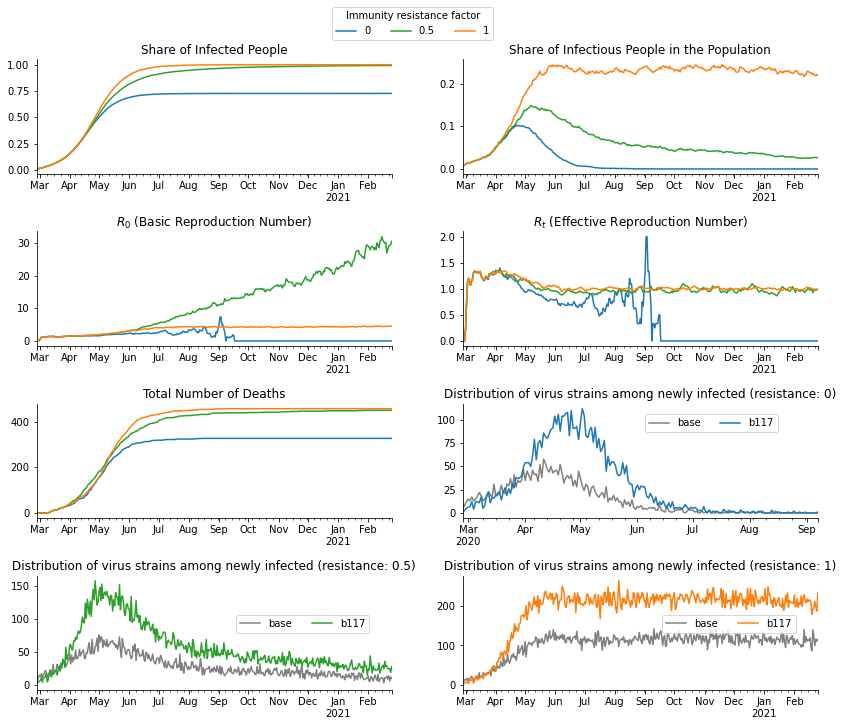

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.5)

axs = axs.flatten()

value_to_ax = {0: 5, 0.5: 6, 1: 7}

for value, color in [(0, "tab:blue"), (0.5, "tab:green"), (1, "tab:orange")]:

    df_dict[value].resample("D", on="date")["ever_infected"].mean().plot(
        ax=axs[0], color=color, label=value
    )
    df_dict[value].resample("D", on="date")["infectious"].mean().plot(
        ax=axs[1], color=color
    )
    df_dict[value].resample("D", on="date")["dead"].sum().plot(ax=axs[4], color=color)

    r_zero = sid.statistics.calculate_r_zero(df_dict[value], window_length=7)
    r_zero.plot(ax=axs[2], color=color)

    r_effective = sid.statistics.calculate_r_effective(df_dict[value], window_length=7)
    r_effective.plot(ax=axs[3], color=color)

    _df = (
        df_dict[value]
        .query("newly_infected")
        .groupby([pd.Grouper(key="date", freq="D"), "virus_strain"])["newly_infected"]
        .count()
        .unstack()
    )
    _df["base"].plot(ax=axs[value_to_ax[value]], color="grey")
    _df["b117"].plot(ax=axs[value_to_ax[value]], color=color)

for ax in axs:
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

axs[0].legend(
    ncol=3,
    bbox_to_anchor=(1.3, 1.5),
    title="Immunity resistance factor",
)
axs[5].legend(loc="upper center", bbox_to_anchor=(0.70, 0.95), ncol=2)
axs[6].legend(loc="upper center", bbox_to_anchor=(0.75, 0.70), ncol=2)
axs[7].legend(loc="upper center", bbox_to_anchor=(0.75, 0.70), ncol=2)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("$R_0$ (Basic Reproduction Number)")
axs[3].set_title("$R_t$ (Effective Reproduction Number)")
axs[4].set_title("Total Number of Deaths")
axs[5].set_title("Distribution of virus strains among newly infected (resistance: 0)")
axs[6].set_title("Distribution of virus strains among newly infected (resistance: 0.5)")
axs[7].set_title("Distribution of virus strains among newly infected (resistance: 1)")

plt.show()